In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

# Introduction to generative adversarial networks

This notebook contains the second code sample found in Chapter 8, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---
[...]

## A schematic GAN implementation


In what follows, we explain how to implement a GAN in Keras, in its barest form -- since GANs are quite advanced, diving deeply into the 
technical details would be out of scope for us. Our specific implementation will be a deep convolutional GAN, or DCGAN: a GAN where the 
generator and discriminator are deep convnets. In particular, it leverages a `Conv2DTranspose` layer for image upsampling in the generator.

We will train our GAN on images from CIFAR10, a dataset of 50,000 32x32 RGB images belong to 10 classes (5,000 images per class). To make 
things even easier, we will only use images belonging to the class "frog".

Schematically, our GAN looks like this:

* A `generator` network maps vectors of shape `(latent_dim,)` to images of shape `(32, 32, 3)`.
* A `discriminator` network maps images of shape (32, 32, 3) to a binary score estimating the probability that the image is real.
* A `gan` network chains the generator and the discriminator together: `gan(x) = discriminator(generator(x))`. Thus this `gan` network maps 
latent space vectors to the discriminator's assessment of the realism of these latent vectors as decoded by the generator.
* We train the discriminator using examples of real and fake images along with "real"/"fake" labels, as we would train any regular image 
classification model.
* To train the generator, we use the gradients of the generator's weights with regard to the loss of the `gan` model. This means that, at 
every step, we move the weights of the generator in a direction that will make the discriminator more likely to classify as "real" the 
images decoded by the generator. I.e. we train the generator to fool the discriminator.

## A bag of tricks


Training GANs and tuning GAN implementations is notoriously difficult. There are a number of known "tricks" that one should keep in mind. 
Like most things in deep learning, it is more alchemy than science: these tricks are really just heuristics, not theory-backed guidelines. 
They are backed by some level of intuitive understanding of the phenomenon at hand, and they are known to work well empirically, albeit not 
necessarily in every context.

Here are a few of the tricks that we leverage in our own implementation of a GAN generator and discriminator below. It is not an exhaustive 
list of GAN-related tricks; you will find many more across the GAN literature.

* We use `tanh` as the last activation in the generator, instead of `sigmoid`, which would be more commonly found in other types of models.
* We sample points from the latent space using a _normal distribution_ (Gaussian distribution), not a uniform distribution.
* Stochasticity is good to induce robustness. Since GAN training results in a dynamic equilibrium, GANs are likely to get "stuck" in all sorts of ways. 
Introducing randomness during training helps prevent this. We introduce randomness in two ways: 1) we use dropout in the discriminator, 2) 
we add some random noise to the labels for the discriminator.
* Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. There are two things 
that can induce gradient sparsity: 1) max pooling operations, 2) ReLU activations. Instead of max pooling, we recommend using strided 
convolutions for downsampling, and we recommend using a `LeakyReLU` layer instead of a ReLU activation. It is similar to ReLU but it 
relaxes sparsity constraints by allowing small negative activation values.
* In generated images, it is common to see "checkerboard artifacts" caused by unequal coverage of the pixel space in the generator. To fix 
this, we use a kernel size that is divisible by the stride size, whenever we use a strided `Conv2DTranpose` or `Conv2D` in both the 
generator and discriminator.

## The generator


First, we develop a `generator` model, which turns a vector (from the latent space -- during training it will sampled at random) into a 
candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like 
noise. A possible solution is to use dropout on both the discriminator and generator.

In [19]:
import keras
from keras import layers
import numpy as np

def build_generator():
    latent_dim = 32
    height = 32
    width = 32
    channels = 3

    generator_input = keras.Input(shape=(latent_dim,))

    # First, transform the input into a 16x16 128-channels feature map
    x = layers.Dense(128 * 16 * 16)(generator_input)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((16, 16, 128))(x)

    # Then, add a convolution layer
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Upsample to 32x32
    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Few more conv layers
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Produce a 32x32 1-channel feature map
    x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
    generator = keras.models.Model(generator_input, x)
    
    return generator

generator = build_generator()
generator.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       1048

## The discriminator


Then, we develop a `discriminator` model, that takes as input a candidate image (real or synthetic) and classifies it into one of two 
classes, either "generated image" or "real image that comes from the training set".

In [20]:
def build_discriminator(is_critic):

    discriminator_input = layers.Input(shape=(height, width, channels))
    x = layers.Conv2D(128, 3)(discriminator_input)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)

    # One dropout layer - important trick!
    x = layers.Dropout(0.4)(x)

    # Classification layer; changes if using WGAN and output is not just 0 or 1
    if is_critic:
        x = layers.Dense(1)(x)
    else:
        x = layers.Dense(1, activation='sigmoid')(x)

    discriminator = keras.models.Model(discriminator_input, x)
    
    return discriminator

discriminator = build_discriminator()
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 6, 6, 128)         0   

## The adversarial network

Finally, we setup the GAN, which chains the generator and the discriminator. This is the model that, when trained, will move the generator 
in a direction that improves its ability to fool the discriminator. This model turns latent space points into a classification decision, 
"fake" or "real", and it is meant to be trained with labels that are always "these are real images". So training `gan` will updates the 
weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images. Very importantly, we 
set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training `gan`. If the 
discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is 
not what we want!

In [5]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## How to train your DCGAN

Now we can start training. To recapitulate, this is schematically what the training loop looks like:

```
for each epoch:
    * Draw random points in the latent space (random noise).
    * Generate images with `generator` using this random noise.
    * Mix the generated images with real ones.
    * Train `discriminator` using these mixed images, with corresponding targets, either "real" (for the real images) or "fake" (for the generated images).
    * Draw new random points in the latent space.
    * Train `gan` using these random vectors, with targets that all say "these are real images". This will update the weights of the generator (only, since discriminator is frozen inside `gan`) to move them towards getting the discriminator to predict "these are real images" for generated images, i.e. this trains the generator to fool the discriminator.
```

Let's implement it:

In [6]:
%%time

import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = 'data/'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/Users/WillLacey/opt/anaconda3/envs/default/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.6901409
adversarial loss at step 0: 0.7005342


/Users/WillLacey/opt/anaconda3/envs/default/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: 

Let's display a few of our fake images:

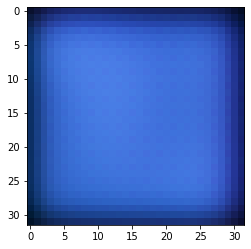

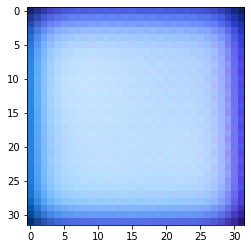

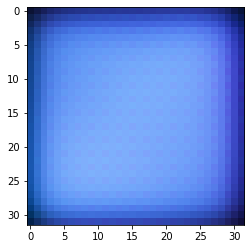

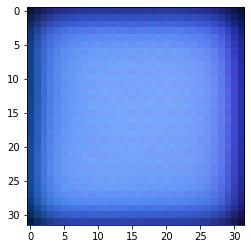

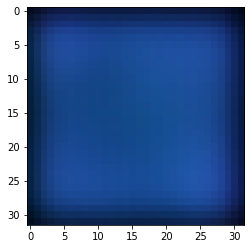

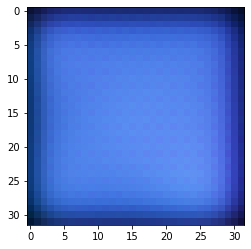

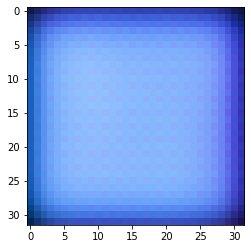

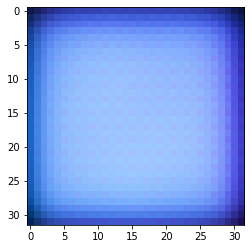

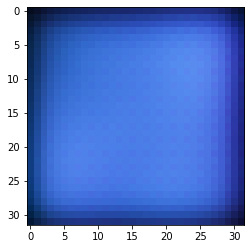

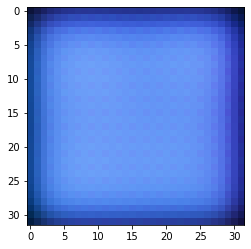

In [8]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Froggy with some pixellated artifacts.

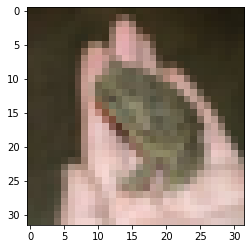

In [17]:
plt.imshow(x_train[90])

# WGAN

The following code was provided by this link here: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py

### Imports

In [5]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

### WGAN Implementation

In [1]:
class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [4]:
if __name__ == '__main__':
    wgan = WGAN()
    wgan.train(epochs=4000, batch_size=32, sample_interval=50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 32)          128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 32)         

/Users/WillLacey/opt/anaconda3/envs/default/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: 

Using TensorFlow backend.
